In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint

In [2]:
var_dir = 'model_runs/5species_badequations/info/variables.dat'

In [3]:
actual_vars = [0.001, 1, 1, 1, 0.0001, 1]

In [4]:
with open(var_dir) as f:
    ind, vars = [], []
    for line in f.readlines():
        spl = line.split(' ', 1)
        ind.append(int(spl[0]))
        var = list(map(float, spl[1][1:-3].split(', ')))
        vars.append(var)
    
    var_dict = dict(zip(ind, vars))

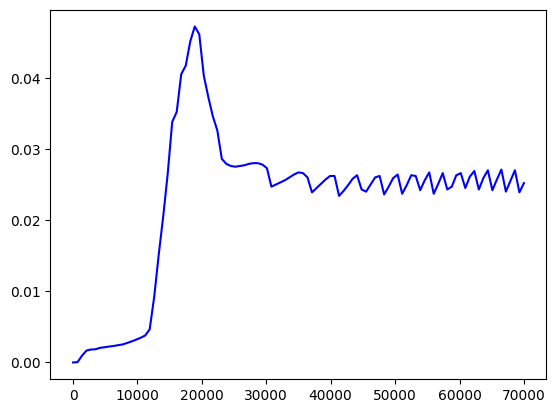

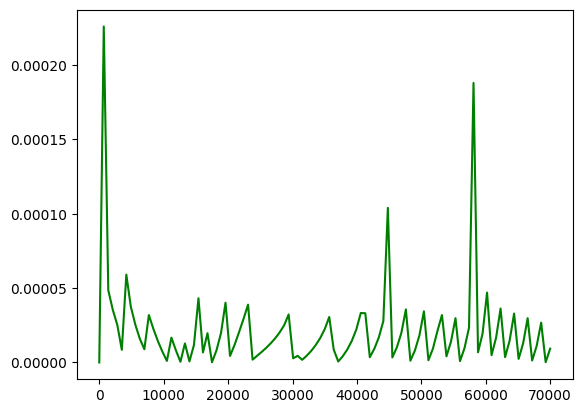

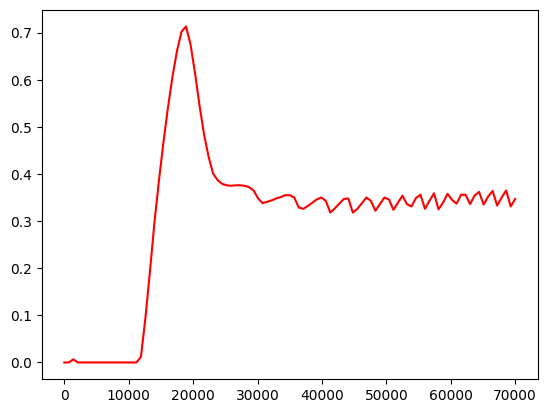

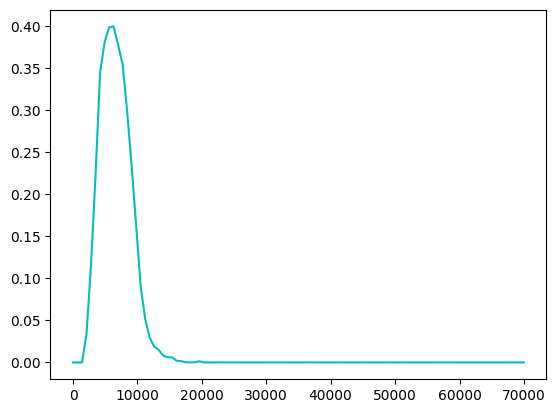

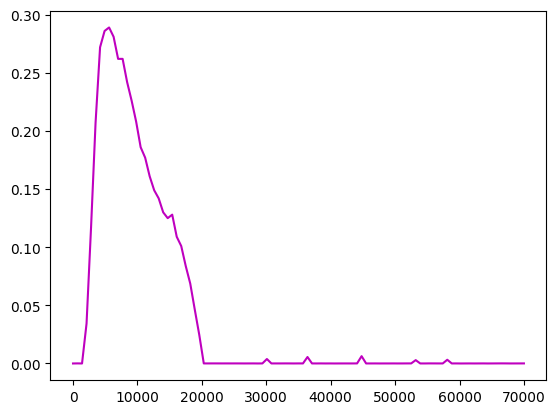

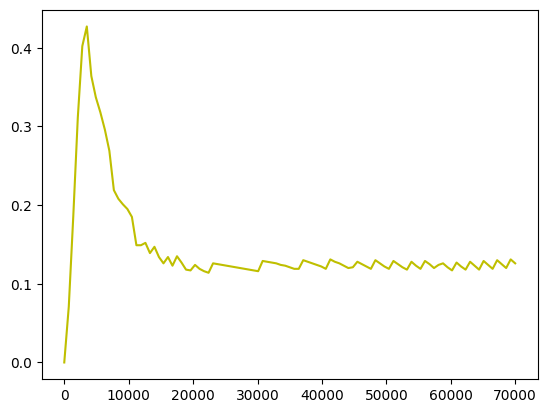

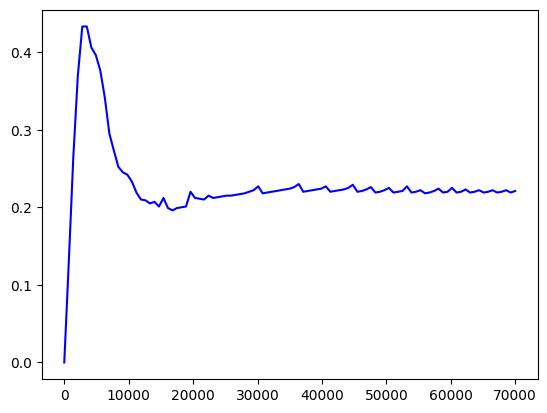

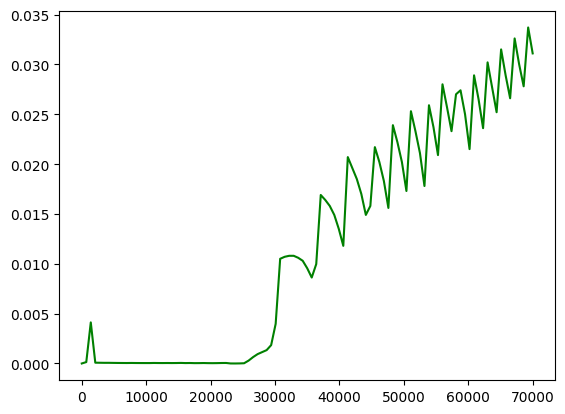

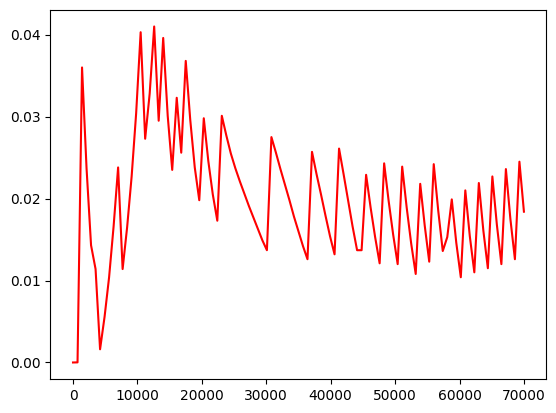

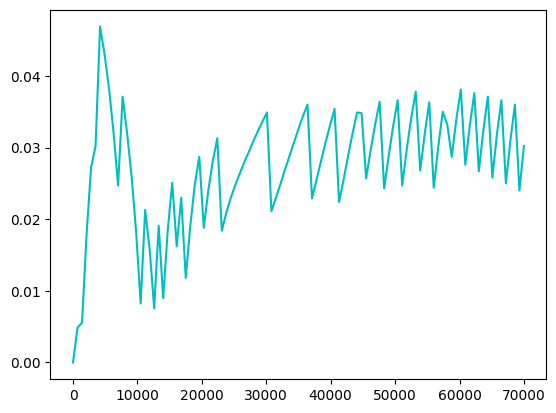

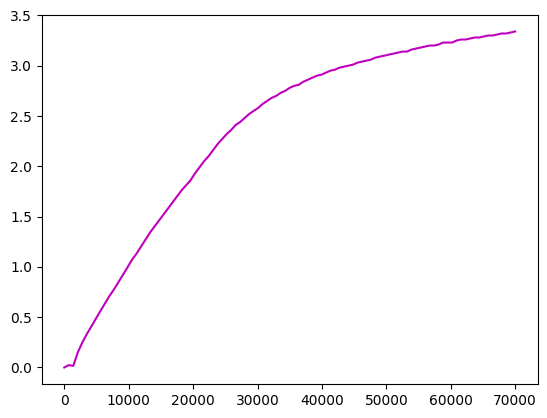

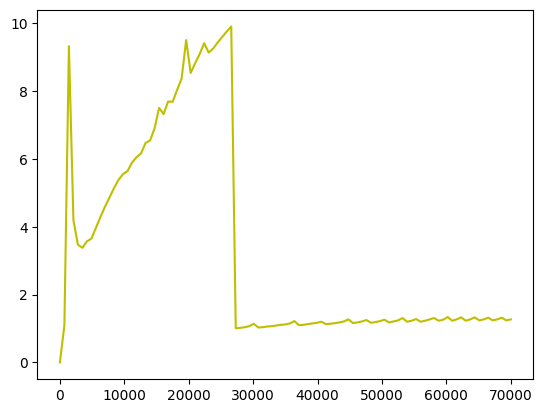

In [5]:
colors='bgrcmybgrcmy'
for i in range(12):
    plt.figure(i)
    plt.plot(var_dict.keys(), [j[i] for j in var_dict.values()], colors[i]+'-')
    # plt.plot(var_dict.keys(), [actual_vars[i]]*len(var_dict), colors[i]+'--')

In [68]:
amylofit = pd.read_csv('amylofit_5_non0ic.csv')

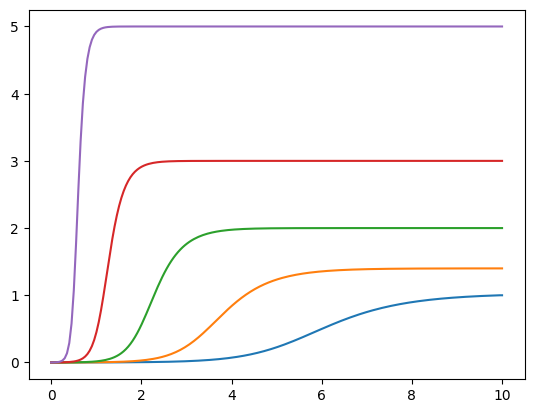

In [69]:
plt.plot(amylofit['t'], amylofit['B1'])
plt.plot(amylofit['t'], amylofit['Bs'])
plt.plot(amylofit['t'], amylofit['Bn'])
plt.plot(amylofit['t'], amylofit['Bj'])
plt.plot(amylofit['t'], amylofit['Bm'])

In [8]:
n,m=12,24

def to_npz(filepath, out_path, x_cols, y_cols):
    df = pd.read_csv(filepath)
    t = []
    y = []
    for _, v in df.iterrows():
        t.append(v[x_cols].to_numpy())
        y.append(v[y_cols].to_numpy())
    np.savez(out_path, t=t, y=y)


def load_training_data(data_path):
    tr_data = np.load(data_path)
    return tr_data['t'], tr_data['y']

def abetaODE(y0, a, b, time):
    # abetaODE(numIter,A,B,C,D,E
    # numIter - total number of initial conditions to simulate
    # A,B,C,D,E - relative concentration IC seedings of B1', Bn, Bn', Bm, Bm'

    # define the model parameters


    # initialize initial condition, and bridge rate loops

    # Define the system of equations
    def f(y, t):
        # y is initial condition vector
        # t is time grid
        B1t = y[0]
        Bnt = y[1]
        Bmt = y[2]

        B1_t = n * a[0] * Bnt - n * a[1] * pow(B1t, n) - a[2] * B1t
        Bn_t = a[1] * pow(B1t, n) - a[0] * Bnt + (m / n) * a[4] * Bmt - a[3] * Bnt - (
                m / n) * b[2] * pow(Bnt, (m / n))
        Bm_t = b[2] * pow(Bnt, (m / n)) - a[4] * Bmt

        return [B1_t, Bn_t, Bm_t]

    soln = odeint(f, y0, time)  # solve the system of equations

    # extract solution for each agent
    df_dict = {
        't': time,
        'B1': soln[:, 0],
        'Bn': soln[:, 1],
        'Bm': soln[:, 2],
    }

    df = pd.DataFrame.from_dict(df_dict, orient='index').transpose()

    df.to_csv('sim_abeta.csv', index=False)
    to_npz('sim_abeta.csv', 'sim_abeta.npz', x_cols=['t'], y_cols=['B1', 'Bn', 'Bm'])

    return df

In [20]:
at, bt = [4.11e-03, 1.20e-02, 4.89e-04, 5.00e-04, 6.82e-03], [0, 0, 4.97e-04, 0, 0, 0]
data = abetaODE([1, 1, 1], at, bt, np.square(np.linspace(0, np.sqrt(10), 199)))

In [21]:
data

,t,B1,Bn,Bm
0,0.000000,1.000000,1.000000,1.000000
1,0.000255,0.999976,1.000005,0.999998
2,0.001020,0.999903,1.000020,0.999994
3,0.002296,0.999782,1.000046,0.999985
4,0.004081,0.999613,1.000082,0.999974
...,...,...,...,...
194,9.600041,0.921413,1.117391,0.941848
195,9.699265,0.921486,1.118477,0.941272
196,9.799000,0.921559,1.119567,0.940694
197,9.899245,0.921633,1.120662,0.940114


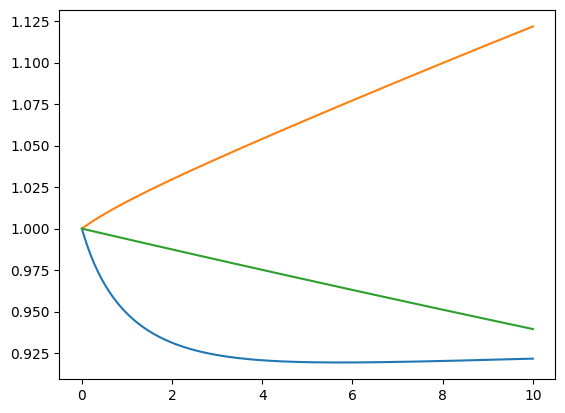

In [22]:
plt.plot(data['t'], data['B1'])
plt.plot(data['t'], data['Bn'])
plt.plot(data['t'], data['Bm'])

In [55]:
data = pd.read_csv('amylofit_5.csv')

In [56]:
t, species = data.t, data.loc[:, data.columns!='t']

In [57]:
t = t.iloc[:-1].reset_index()

In [58]:
species = species.iloc[1:,:].reset_index()

In [59]:
species

,index,B1,Bs,Bn,Bj,Bm
0,1,0.000001,0.000004,0.000011,0.000037,0.000178
1,2,0.000006,0.000015,0.000044,0.000152,0.000825
2,3,0.000013,0.000034,0.000100,0.000362,0.002356
3,4,0.000022,0.000060,0.000182,0.000694,0.005752
4,5,0.000035,0.000095,0.000293,0.001191,0.013175
...,...,...,...,...,...,...
194,195,0.995196,1.399929,2.000000,3.000000,5.000000
195,196,0.996470,1.399948,2.000000,3.000000,5.000000
196,197,0.997694,1.399967,2.000000,3.000000,5.000000
197,198,0.998870,1.399984,2.000000,3.000000,5.000000


In [60]:
final = pd.concat([t, species], axis=1)

In [62]:
final = final.iloc[:,final.columns!='index']

In [64]:
final.loc[len(final.index)] = [10.0, 1.0, 1.4, 2.0, 3.0, 5.0]

C:\Users\ayush\AppData\Local\Temp\ipykernel_18656\3810914347.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final.loc[len(final.index)] = [10.0, 1.0, 1.4, 2.0, 3.0, 5.0]


In [65]:
final

,t,B1,Bs,Bn,Bj,Bm
0,0.000000,0.000001,0.000004,0.000011,0.000037,0.000178
1,0.050251,0.000006,0.000015,0.000044,0.000152,0.000825
2,0.100503,0.000013,0.000034,0.000100,0.000362,0.002356
3,0.150754,0.000022,0.000060,0.000182,0.000694,0.005752
4,0.201005,0.000035,0.000095,0.000293,0.001191,0.013175
...,...,...,...,...,...,...
195,9.798995,0.996470,1.399948,2.000000,3.000000,5.000000
196,9.849246,0.997694,1.399967,2.000000,3.000000,5.000000
197,9.899497,0.998870,1.399984,2.000000,3.000000,5.000000
198,9.949749,1.000000,1.400000,2.000000,3.000000,5.000000


In [67]:
final.to_csv('amylofit_5_non0ic.csv', index=False)

In [4]:
from Hypergraph.species_hypergraph import SpeciesHypergraph

In [14]:
graph = SpeciesHypergraph([1, 8, 12, 14, 24])

In [15]:
graph.create_graph(include_multiterm_rxns=False)

In [16]:
print(graph)

e1 {'tail': [B1], 'head': [B8], 'weight': 1, 'rxn': [8B1 <a2--a1> B8]}
e2 {'tail': [B1], 'head': [B12], 'weight': 1, 'rxn': [12B1 <a4--a3> B12]}
e4 {'tail': [B1], 'head': [B14], 'weight': 1, 'rxn': [14B1 <a8--a7> B14]}
e7 {'tail': [B1], 'head': [B24], 'weight': 1, 'rxn': [24B1 <b5--b4> B24]}
e13 {'tail': [B8], 'head': [B24], 'weight': 1, 'rxn': [3B8 <d1--c9> B24]}
e14 {'tail': [B12], 'head': [B24], 'weight': 1, 'rxn': [2B12 <d3--d2> B24]}



In [17]:
import sympy as sp

In [18]:
sp.init_printing()

In [19]:
graph.get_diffeq(12)